In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

## Hyperparameters

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0002
num_workers = 0
img_shape = (1, 28, 28)
g_input_dim = 100
num_epochs = 100
g_output_dim = 784
classes = 10
embed_dim = 10

## MNIST Dataset

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

In [0]:
train_data = datasets.MNIST(root= "data", train = True, transform= transform, download= True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, num_workers= num_workers)

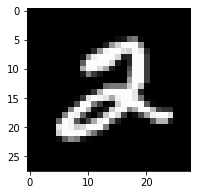

In [5]:
def visualize(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = images / 2 + 0.5  
    images = images.numpy()
    
    #get one image in batch
    img = np.squeeze(images[5])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

visualize(train_loader)

## Define the model

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_ouput_dim, embed_dim,classes):
        super(Generator, self).__init__()
        self.embed_layer = nn.Embedding(classes, embed_dim)
        self.main= nn.Sequential(
            nn.Linear(g_input_dim + embed_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, g_ouput_dim),
            nn.Tanh()
        )
        self.input_dim = g_input_dim
    
    def forward(self, z, labels):
        z = z.view(z.size(0), self.input_dim)
        y = self.embed_layer(labels)
        x = torch.cat([z, y], 1)
        out = self.main(x)
        return out

## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, g_ouput_dim, embed_dim,classes):
        super(Discriminator, self).__init__()
        self.embed_layer = nn.Embedding(classes, embed_dim)
        self.main = nn.Sequential(
            nn.Linear(g_ouput_dim + embed_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        self.input_dim = g_output_dim

    def forward(self, img, labels):
        x = img.view(img.size(0), self.input_dim)
        y = self.embed_layer(labels)
        x = torch.cat([x, y], 1)
        out = self.main(x)
        return out

In [8]:
G = Generator(g_input_dim, g_output_dim, embed_dim, classes).to(device)
D = Discriminator(g_output_dim, embed_dim, classes).to(device)

print(G)
print(D)

Generator(
  (embed_layer): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (embed_layer): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): 

## Define Losses and Optimizers

In [0]:
def real_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device)
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device) # fake labels = 0
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Training

In [11]:
D.train()
G.train()
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.long().to(device)
        #TRAIN DISCRIMINATOR
        d_optimizer.zero_grad()

        #Train with real images
        D_real = D(real_images, labels)
        d_real_loss = real_loss(D_real)

        #Train with fake images
        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, classes, batch_size)).to(device)
        fake_images = G(z, fake_labels)
        D_fake = D(fake_images, fake_labels)
        d_fake_loss = fake_loss(D_fake)

        #Combine loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        #TRAIN GENERATOR
        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, classes, batch_size)).to(device)
        fake_images = G(z, fake_labels)
        D_fake = D(fake_images, fake_labels)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()
    
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
        epoch+1, num_epochs, d_loss.item(), g_loss.item()))

Epoch [    1/  100] | d_loss: 1.4900 | g_loss: 0.7270
Epoch [    2/  100] | d_loss: 0.9667 | g_loss: 1.5630
Epoch [    3/  100] | d_loss: 0.1250 | g_loss: 4.2428
Epoch [    4/  100] | d_loss: 0.4021 | g_loss: 3.2741
Epoch [    5/  100] | d_loss: 1.0070 | g_loss: 2.2927
Epoch [    6/  100] | d_loss: 0.4646 | g_loss: 2.5087
Epoch [    7/  100] | d_loss: 1.0992 | g_loss: 2.0206
Epoch [    8/  100] | d_loss: 0.9270 | g_loss: 1.5521
Epoch [    9/  100] | d_loss: 0.6689 | g_loss: 1.7525
Epoch [   10/  100] | d_loss: 0.9706 | g_loss: 1.2958
Epoch [   11/  100] | d_loss: 0.6526 | g_loss: 1.1519
Epoch [   12/  100] | d_loss: 0.8299 | g_loss: 2.1665
Epoch [   13/  100] | d_loss: 0.7031 | g_loss: 1.9549
Epoch [   14/  100] | d_loss: 0.8497 | g_loss: 1.4841
Epoch [   15/  100] | d_loss: 0.7233 | g_loss: 1.1007
Epoch [   16/  100] | d_loss: 1.0029 | g_loss: 0.9073
Epoch [   17/  100] | d_loss: 0.9344 | g_loss: 1.3593
Epoch [   18/  100] | d_loss: 1.1290 | g_loss: 1.0975
Epoch [   19/  100] | d_loss

## Evaluation

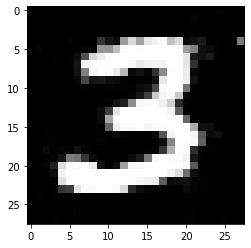

In [48]:
def generate(digit):
    rand_z = np.random.uniform(-1, 1, size= (1, g_input_dim))
    rand_z = torch.from_numpy(rand_z).float().to(device)
    label = torch.LongTensor([digit]).to(device)
    img = G(rand_z, label).data.cpu()
    img = 0.5 * img + 0.5
    plt.imshow(img.reshape((28,28)).to("cpu"), cmap='Greys_r')
generate(3)